In [1]:
# Regularization: Ridge, LASSO, Elastic Net
# based on D. Bette that was based on J. Nagler
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Define models

In [2]:
# Min: ||y - Xw||^2_2 + alpha * ||w||^2_2
def do_ridge(lambdaaa,X_train,y_train,X_test,y_test):
    ridge = Ridge(alpha=lambdaaa, max_iter=int(10e5))
    ridge.fit(X_train,y_train)
    ridge_train_score=ridge.score(X_train,y_train)
    ridge_test_score=ridge.score(X_test,y_test)
    ridge_num_features = np.sum(ridge.coef_!=0)
    ridge_coef = ridge.coef_
    return [round(lambdaaa, 4), round(ridge_train_score, 4), round(ridge_test_score, 4), ridge_num_features], list(ridge_coef)

# Min: cN ||y - Xw||^2_2 + alpha * ||w||_1
def do_lasso(lambdaaa,X_train,y_train,X_test,y_test): #do not use "lambda" as variable
    lasso = Lasso( alpha=lambdaaa )
    lasso.fit( X_train,y_train )
    lasso_train_score=lasso.score( X_train,y_train )
    lasso_test_score=lasso.score( X_test,y_test )
    lasso_num_features = np.sum( lasso.coef_!=0 )
    lasso_coef = lasso.coef_
    return [round(lambdaaa, 4), round(lasso_train_score, 4), round(lasso_test_score, 4), lasso_num_features], list(lasso_coef)

# Min: cN ||y - Xw||^2_2 + c1 ||w||_1 + c2 ||w||^2_2
def do_elastic(lambdaaa,X_train,y_train,X_test,y_test):
    elast = ElasticNet(alpha=lambdaaa, l1_ratio=0.5, max_iter=int(10e5)) # L1-Ratio is set to fixed value for comparison
    elast.fit(X_train,y_train)
    elast_train_score=elast.score(X_train,y_train)
    elast_test_score=elast.score(X_test,y_test)
    elast_num_features = np.sum(elast.coef_!=0)
    elast_coef = elast.coef_
    return [round(lambdaaa, 4), round(elast_train_score, 4), round(elast_test_score, 4), elast_num_features], list(elast_coef)

In [3]:
#package 

def compare(X,y,feature_names):
    #X = pd.get_dummies(X)
    # Split data into train and test datasets and use statify sampling
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2,
                                                        #stratify=y, 
                                                        random_state=42)
    
    sc = MinMaxScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    results, coefficient = [], []

    for i in np.logspace(-4, np.log10(1), 100):   
        run, coef_run = do_lasso(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)
    temp_1,temp_2 = [],[]
    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    lasso_results = pd.concat([temp_1, temp_2], axis=1)

    results, coefficient = [], []

    for i in np.logspace(-4, np.log10(1), 100):    
        run, coef_run = do_ridge(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)

    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    ridge_results = pd.concat([temp_1, temp_2], axis=1)   

    results, coefficient = [], []

    for i in  np.logspace(-4, np.log10(1), 100):     
        run, coef_run = do_elastic(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)

    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    elastic_results = pd.concat([temp_1, temp_2], axis=1)

    elastic_cv = ElasticNetCV(l1_ratio=np.linspace(0.001, 0.999, num=10), 
                            n_alphas=100,
                            cv=10, 
                            random_state=42)

    elastic_cv.fit(X_train,y_train)
    elastic_cv_train_score=round(elastic_cv.score(X_train,y_train), 4)
    elastic_cv_test_score=round(elastic_cv.score(X_test,y_test), 4)
    elastic_cv_num_features = np.sum(elastic_cv.coef_!=0)
    lambda1 = round(elastic_cv.alpha_, 4)

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]

    plt.figure(figsize=(18, 6))
    for i in range(0,3):
        name = plot_names[i]
        data = plot_data[i]
        plt.subplot(1, 3, i+1)
        if i == 2:
            plt.plot(np.ones(5)*lambda1,np.linspace(0,1,5),label= "cv lambda")
        plt.plot(data["Lambda"], data["Train Score"], label="Train Score")
        plt.plot(data["Lambda"], data["Test Score"], label="Test Score")
        plt.xlabel("Lambda")
        plt.ylabel("Score")
        #plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xscale('log')
        plt.legend()
        plt.title(name)
    plt.show()

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]

    plt.figure(figsize=(12, 6))
    for i in range(1,3):
        plt.subplot(1,2,i)
        for name, data in zip(plot_names, plot_data):
            plt.plot(data["Lambda"], data["Number of features"], label=name)    
        plt.xlabel("Lambda")
        plt.ylabel("Number of features")
        if i == 1:
            plt.xscale('log')
        plt.legend()
        plt.title("Comparison of the number of features \nover different Lambdas")
    plt.show()

    # Plot coefficients

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]
    coefficient_names = feature_names

    plt.figure(figsize=(18, 6))
    for i in range(0,3):
        name = plot_names[i]
        data = plot_data[i]
        plt.subplot(1, 3, i+1)
        if i == 2:
            plt.plot(np.ones(5)*lambda1,np.linspace(-np.max(data),np.max(data),5),label= "cv lambda")
        for column in coefficient_names:
            plt.plot(data["Lambda"], data[column], label="Train Score")
            plt.ylim(-np.max(data)*1.1,np.max(data)*1.1)
            plt.xlabel("Lambda")
            plt.ylabel("Coefficient")
            plt.xscale('log')
            plt.title(name)
    plt.show()

    print("Train Score: " + str(elastic_cv_train_score))
    print("Test Score: " + str(elastic_cv_test_score))
    print("L1 Ratio: " + str(round(elastic_cv.l1_ratio_, 1)))
    print("Lambda: " + str(round(elastic_cv.alpha_, 4)))

In [31]:
### heatmap for the correlation matrix
def heatmap(df, name):
    corr_matrix = df.corr()

    plt.figure(figsize=(10, 8))

    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)

    plt.title(f'Feature Correlation Matrix {name}')
    # Show the plot
    plt.show()

In [49]:
### Important features sorted
def important_features(X,y, feature_names):

    # Assuming X_train is your feature set and y_train is the target variable
    # Fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients
    coefficients = model.coef_

    # Create a pandas series with feature names and coefficients
    feature_importance = pd.Series(coefficients, index=feature_names)

    # Sort the features based on the absolute values of their coefficients
    sorted_features = feature_importance.abs().sort_values(ascending=False)

    # Plot the sorted coefficients for visualization
    plt.figure(figsize=(10, 8))
    sorted_features.plot(kind='bar')
    plt.title('Feature Importance based on Linear Model Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Magnitude')
    plt.show()


### Diabetes dataset

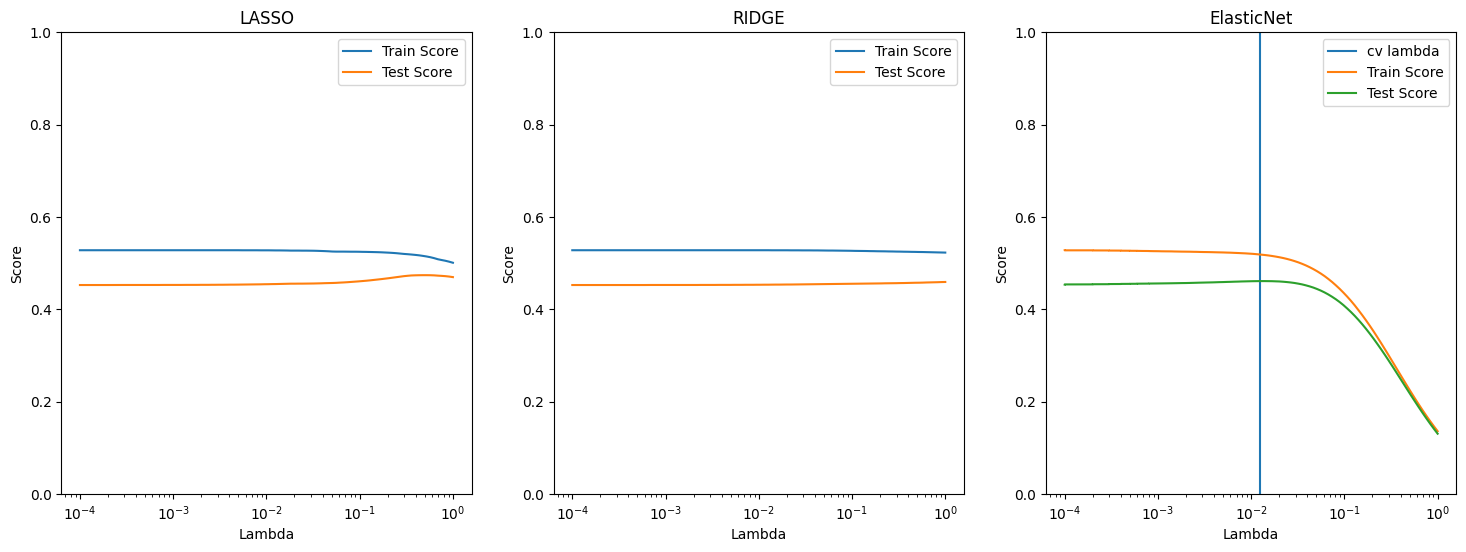

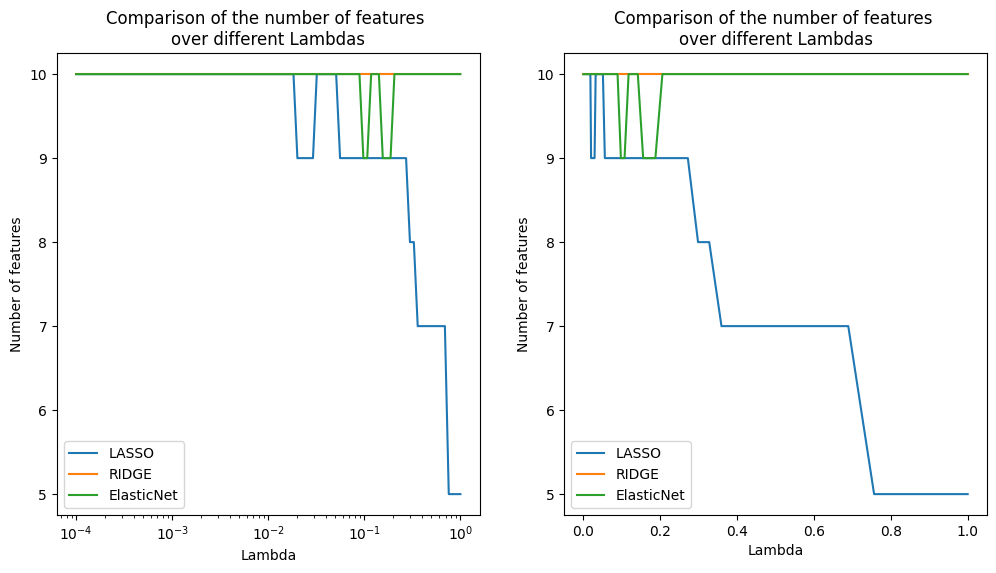

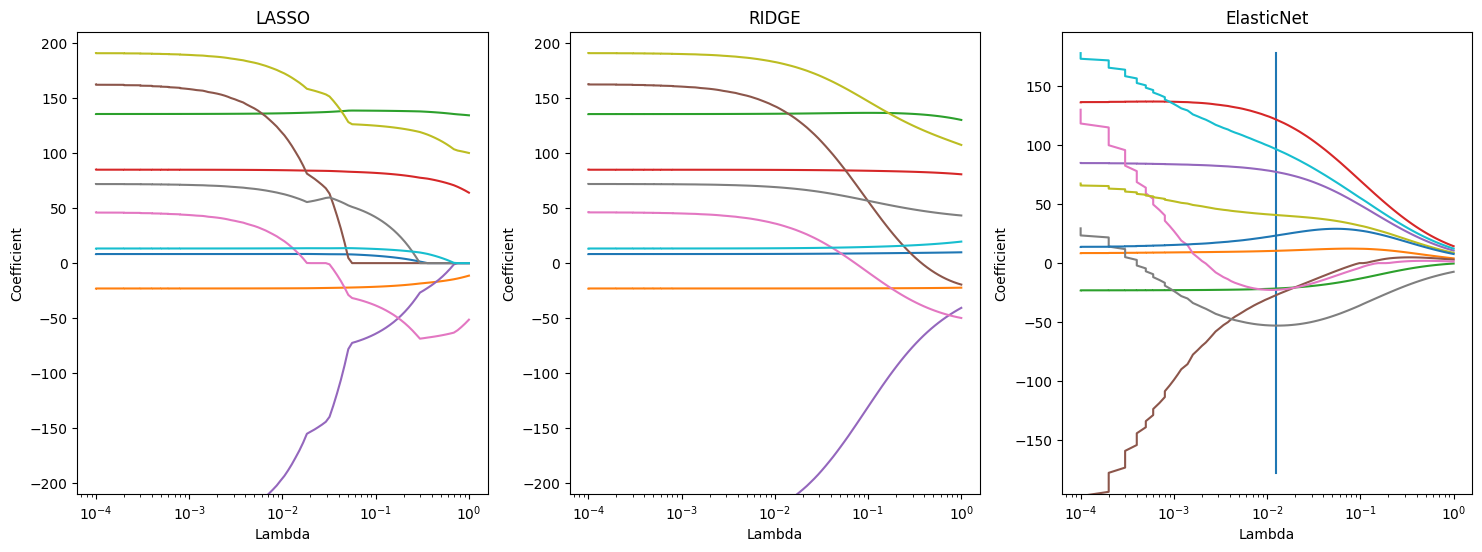

Train Score: 0.5228
Test Score: 0.4596
L1 Ratio: 0.8
Lambda: 0.0123


In [40]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
feature_names = diabetes.feature_names
compare(X,y,feature_names)

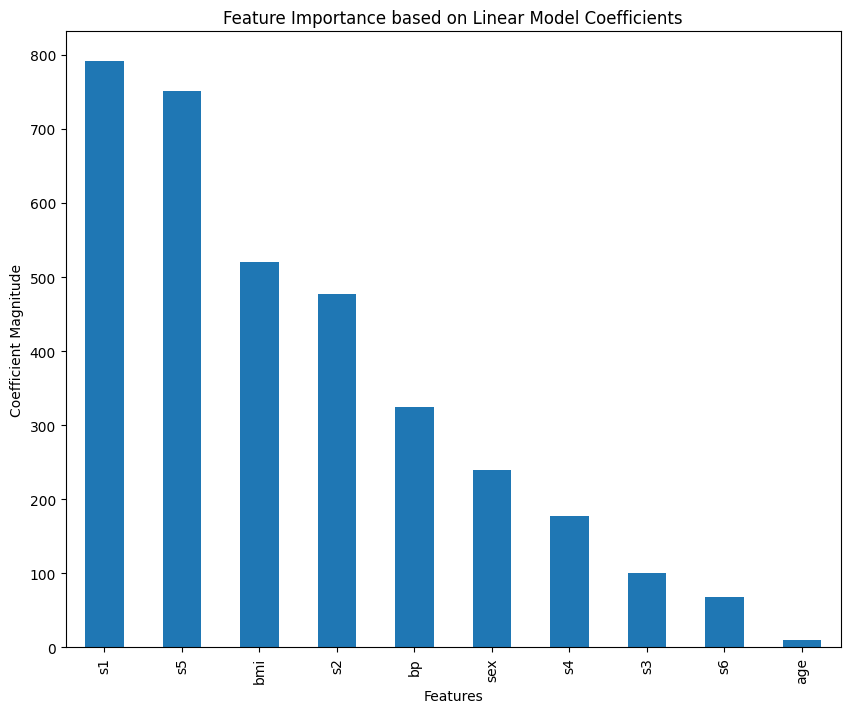

In [50]:
important_features(X, y, diabetes.feature_names)

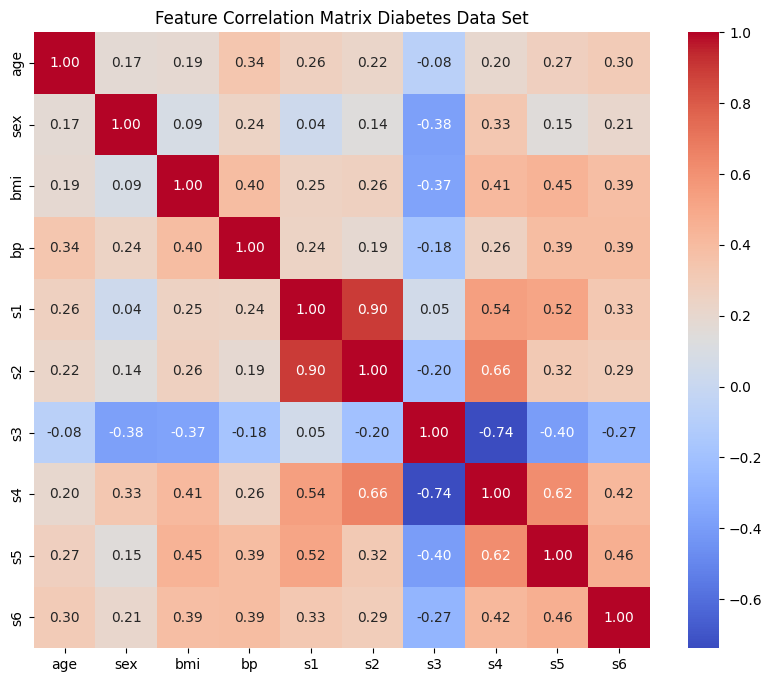

In [33]:
df_diabities = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
heatmap(df_diabities, 'Diabetes Data Set')

### housing prices data set

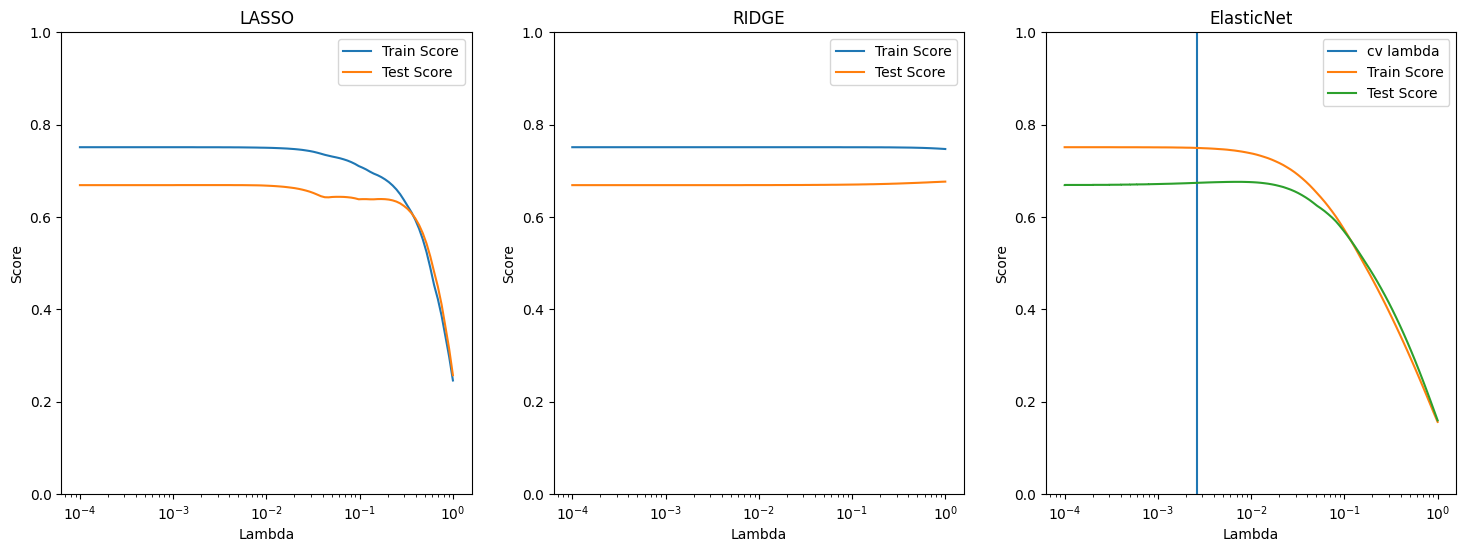

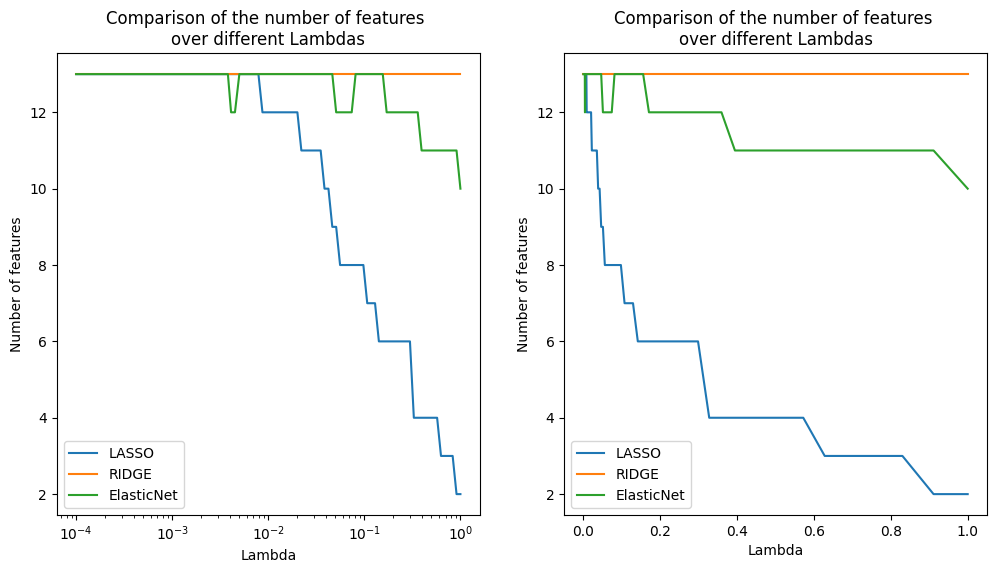

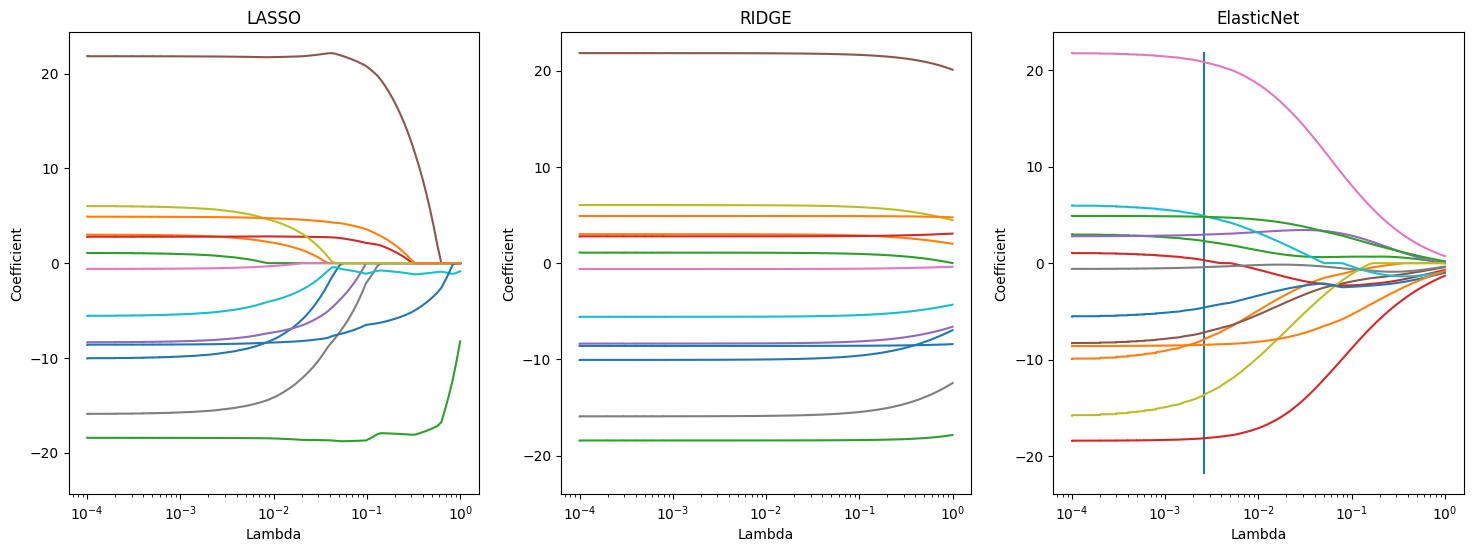

Train Score: 0.7495
Test Score: 0.6734
L1 Ratio: 0.6
Lambda: 0.0026


In [51]:
from sklearn.datasets import fetch_openml
import numpy as np
#wilt = fetch_openml('mnist_784', version=1, as_frame=True)
wilt = fetch_openml('boston', version=1, as_frame=True)
X = wilt.data
y = wilt.target
feature_names = wilt.feature_names
compare(X,y,feature_names)

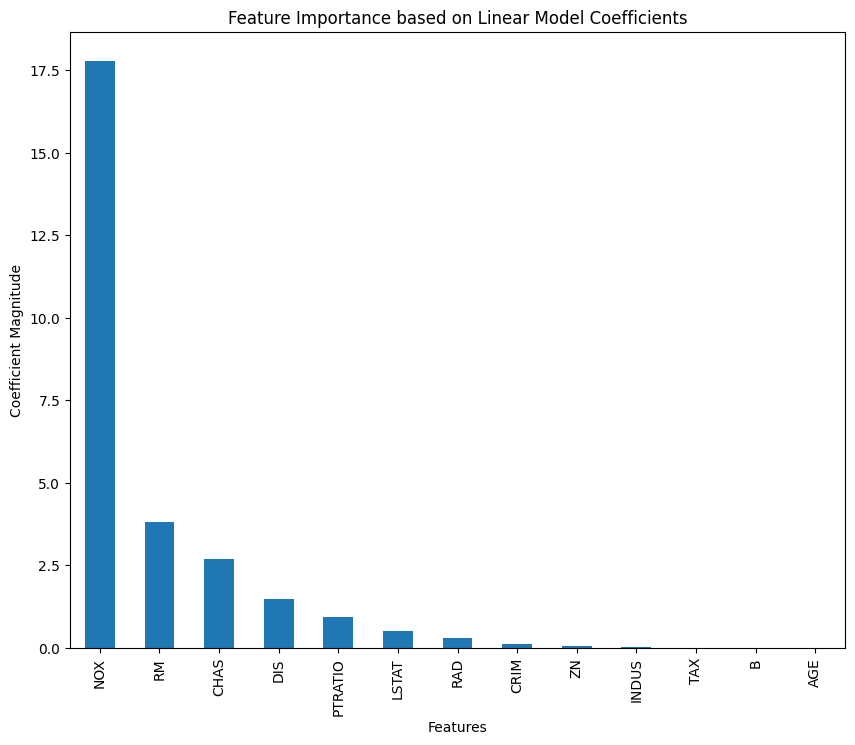

In [52]:
important_features(X, y, feature_names)

**NOX** (Nitric Oxides concentration): The NOX feature has the largest coefficient, indicating a strong relationship with housing prices. In urban planning and environmental studies, it's well-established that higher concentrations of pollutants can decrease the desirability of an area, leading to lower property values.

**RM** (Average number of rooms per dwelling): This feature typically has a direct relationship with house prices. More rooms usually indicate more space, which directly translates to a higher price.

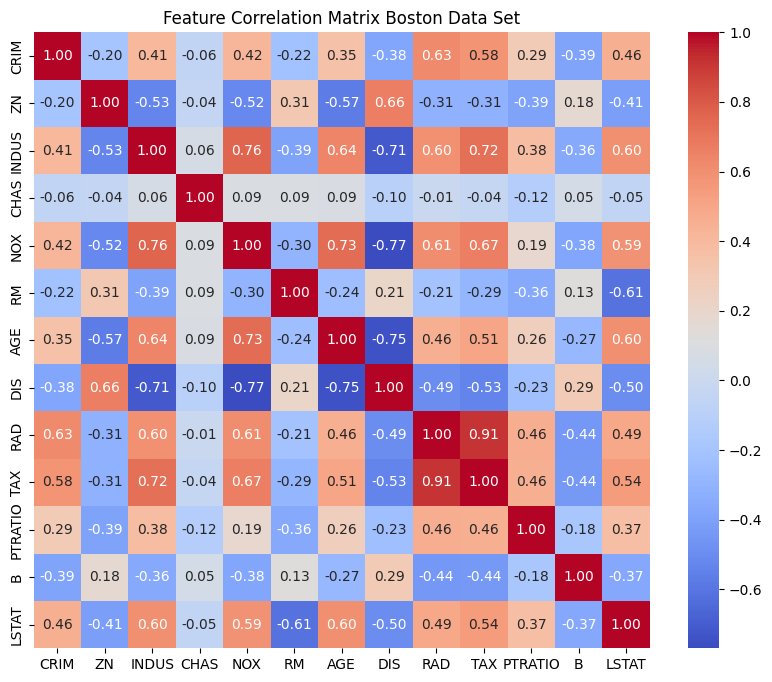

In [34]:
### Correlation of differnet features
df_boston = wilt.data
heatmap(df_boston, 'Boston Data Set')

**Potential Insights:** The matrix suggests potential relationships that could be investigated further, such as:
- A strong positive correlation between NOX and INDUS, which might suggest that as industrial activity (INDUS) increases, air pollution (NOX) also increases.
- A strong negative correlation between DIS and INDUS, which could indicate that as the distance from employment centers increases, the level of industrial activity decreases.

**Consistency with Domain Knowledge:** The correlations match what one might expect. For example, TAX (tax rate) and RAD (accessibility to highways) tend to be positively correlated as areas with better transportation infrastructure may have higher taxes.

# (!!!!!) I'm not sure if we want to include this dataset as well, we need only one, and its already feels like to much

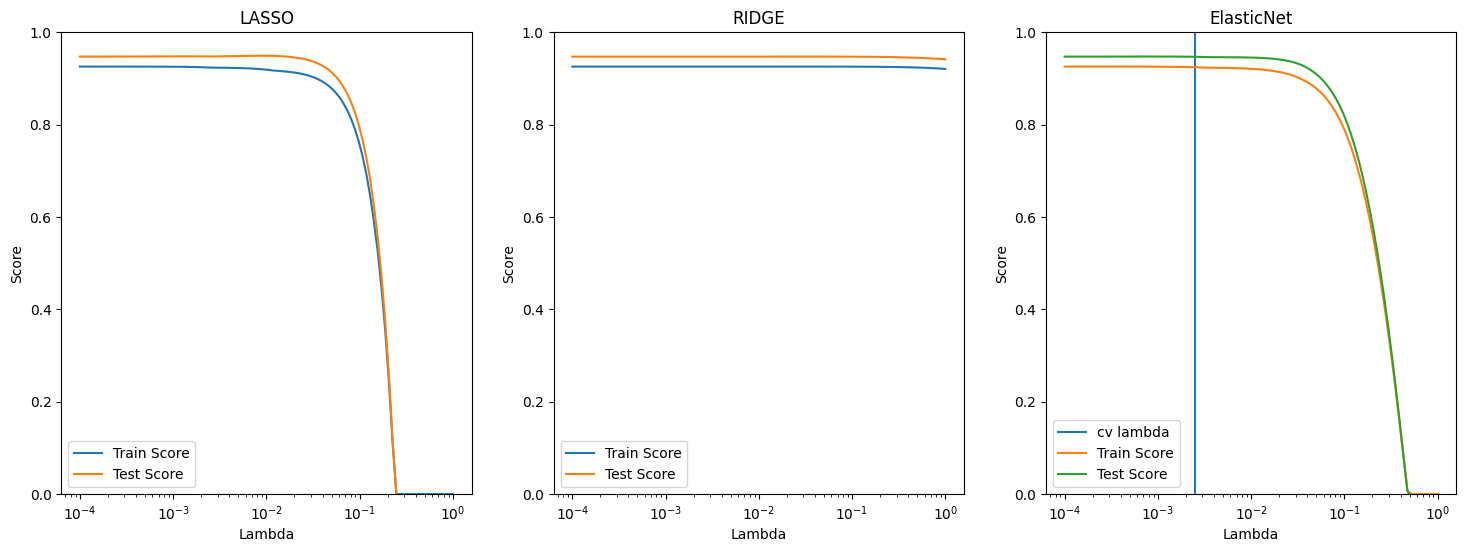

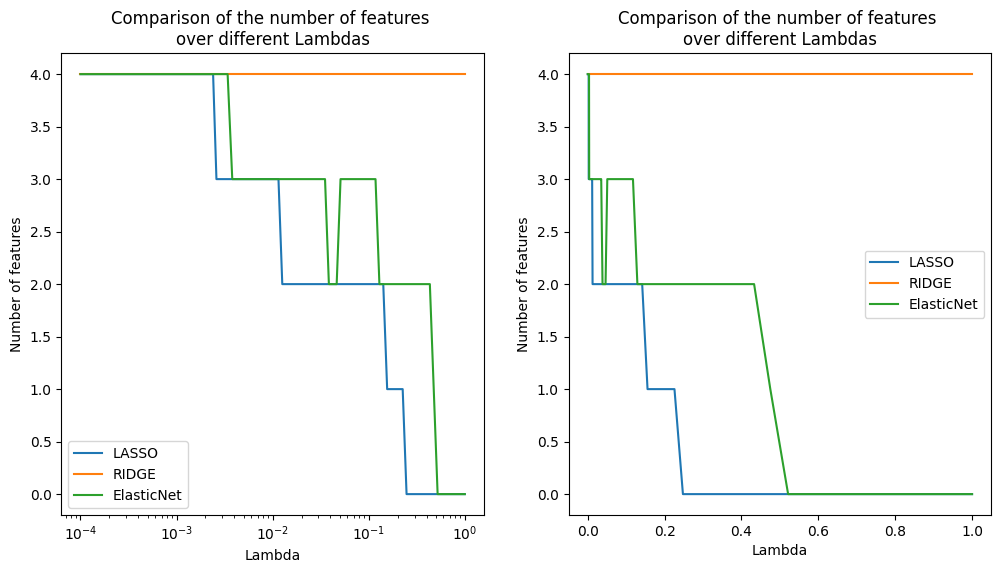

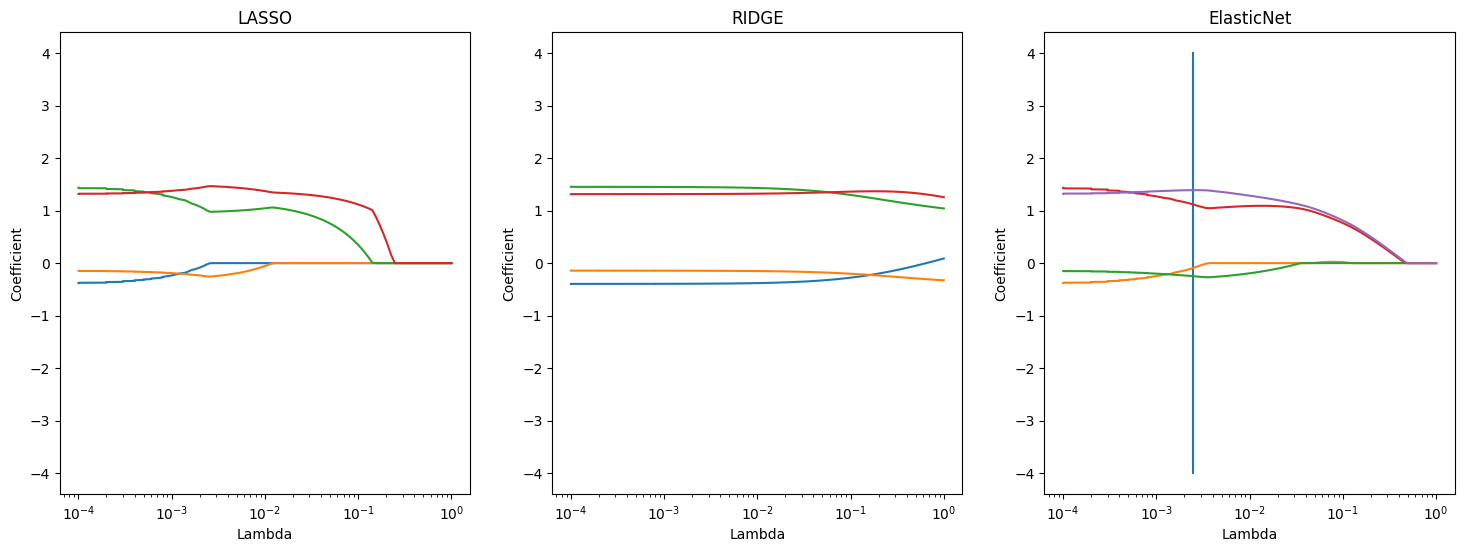

Train Score: 0.9244
Test Score: 0.9459
L1 Ratio: 0.1
Lambda: 0.0025


In [53]:
# Load the diabetes dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
compare(X,y,feature_names)

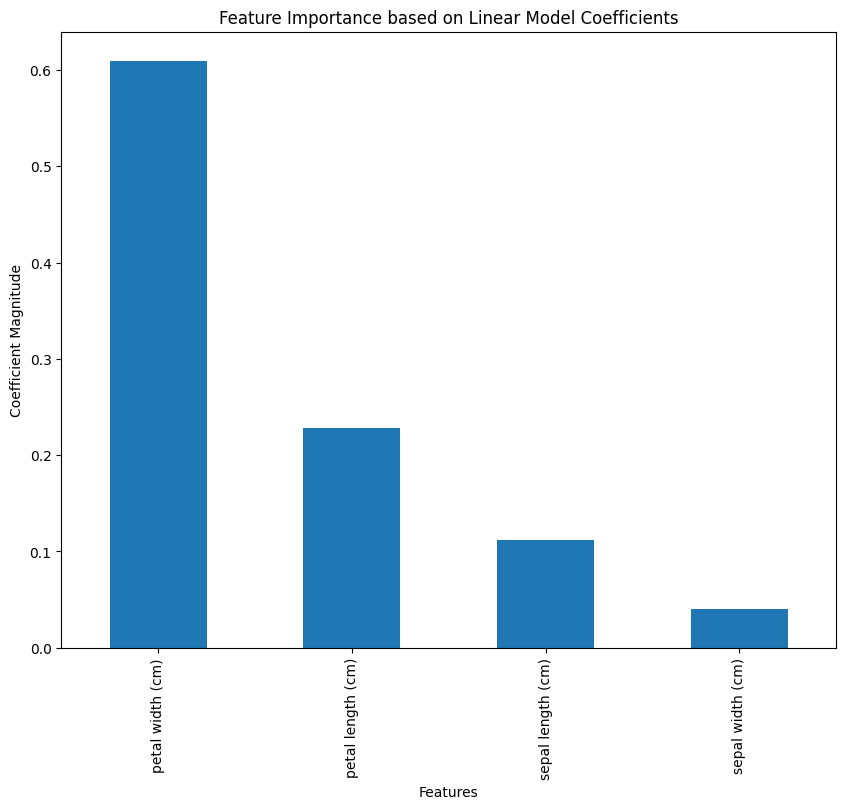

In [54]:
important_features(X,y, feature_names)

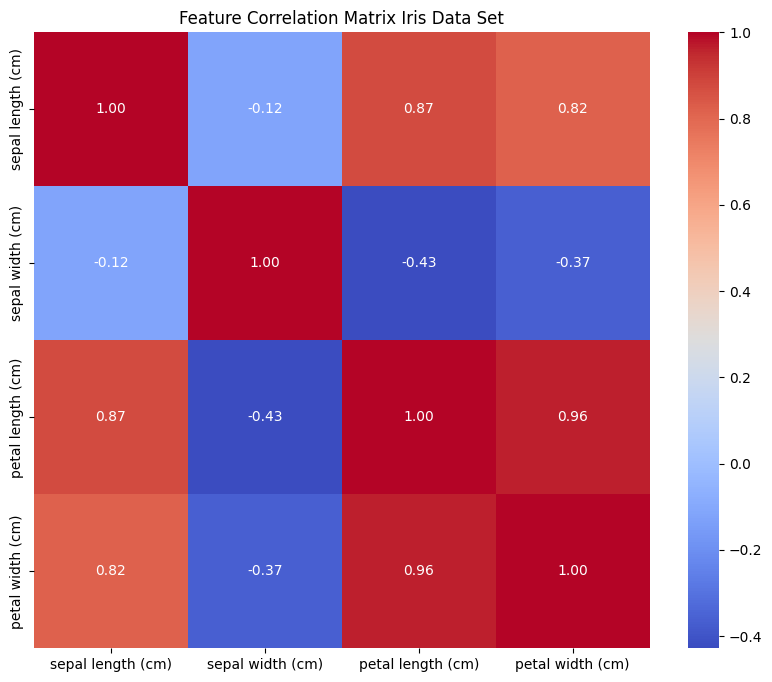

In [39]:
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
heatmap(df_iris, 'Iris Data Set')